In [236]:
# 데이터 세트 준비하기

In [237]:
import numpy as np
import matplotlib.pyplot as plt

In [238]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()

In [239]:
x = cancer.data
y = cancer.target

In [240]:
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, 
                                                           test_size=0.2, random_state=42)

In [241]:
# 로지스틱 회귀로 모델 훈련하고 평가하기

In [242]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

In [243]:
# 서포트 벡터 머신으로 모델 훈련하고 평가하기

In [244]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='hinge', random_state=42)    # 튜닝
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

In [245]:
# 서포트 벡터 머신으로 모델을 훈련하니까 결과가 좋아졌다. 
# 이런 것을 모델을 튜닝한다라고 한다. 
# 하지만 이 모델은 실전에서 좋은 결과를 내지 못할 가능성이 크다. 

In [246]:
# -> 테스트 세트에 대해서만 좋은 성능을 낼 수 있도록 모델을 튜닝했기 때문이다. 

In [247]:
## 검증 세트 준비하기

In [248]:
# 검증 세트 분할하기

In [249]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, 
                                                 stratify=y_train_all, test_size=0.2, random_state=42)

In [250]:
print(len(x_train), len(x_val))

364 91


In [251]:
# 검증 세트 사용해 모델 평가하기

In [252]:
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

0.6923076923076923

In [253]:
# 위 점수가 아주 낮게 나왔다. -> 훈련 세트의 크기가 줄어들었기 때문이다.

In [254]:
## 스케일을 조정하지 않고 모델을 훈련해 보자.

['mean perimeter' 'mean area']


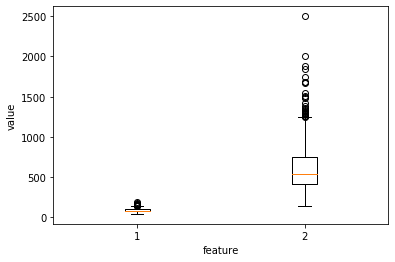

In [255]:
print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [256]:
class SingleLayer:

    def __init__(self, learning_rate=0.1):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []       # 추가 05_02
        self.w_history = []        # 추가 05_01
        self.lr = learning_rate    # 추가 05_01, 가중치의 업데이트 양을 조절
                                   # 손실 함수의 표면을 천천히 이동하며 전역 최솟값을 찾는다.

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b
        return z

    def backprop(self, x, err):
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):# 검증 세트를 전달받을 수 있도록 매개변수 추가
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())
        np.random.seed(42)
        for i in range(epochs):
            loss = 0
            # 인덱스를 섞는다
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:                     # 모든 샘플에 대해 반복한다.
                z = self.forpass(x[i])            # 정방향 계산
                a = self.activation(z)            # 활성화 함수 적용
                err = -(y[i] - a)                 # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err)    # 역방향 계산
                self.w -= self.lr * w_grad        # 가중치 업데이트(학습률 적용) 
                self.b -= b_grad                  # 절편 업데이트
                # 가중치를 기록한다
                self.w_history.append(self.w.copy())
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적한다.
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장한다
            self.losses.append(loss/len(y))
            # 검증 세트에 대한 손실을 계산한다
            self.update_val_loss(x_val, y_val)

    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]        
        return np.array(z) > 0

    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    
    # 검증 손실 계산하기
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])    # 정방향 계산
            a = self.activation(z)        # 활성화 함수 적용
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))    # 손실 함수 
        self.val_losses.append(val_loss/len(y_val))

In [257]:
## 스케일을 조정해 모델을 훈련한다. 

In [258]:
#1. 넘파이로 표준화 구현하기

In [259]:
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

In [260]:
#2. 모델 훈련하기

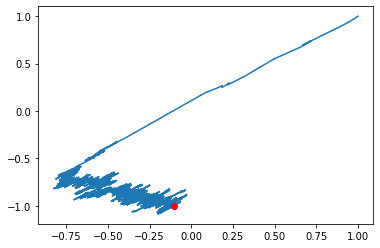

In [261]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2 = []
w3 = []
for w in layer2.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')

In [262]:
#3. 모델 성능 평가하기

In [263]:
layer2.score(x_val, y_val)

0.37362637362637363

In [264]:
# 위 모델이 성능이 좋지 않은 이유는? 검증 세트의 스케일을 바꾸지 않았기 때문이다. 

In [265]:
# val_mean = np.mean(x_val, axis=0)                # 검증 세트를 검증 세트의 평균과 표준편차로 
# val_std = np.std(x_val, axis=0)                  # -> 전처리하면 안 된다. 

x_val_scaled = (x_val - train_mean) / train_std    # 검증 세트를 훈련 세트와 같은 비율로 전처리해야 한다.
layer2.score(x_val_scaled, y_val)

0.967032967032967

In [267]:
# 모델 훈련하기

In [268]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

In [ ]:
# 손실값으로 그래프 그려 에포크 횟수 지정하기

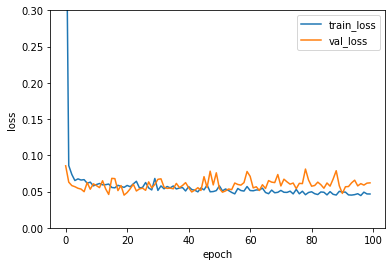

In [269]:
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [270]:
# 훈련 조기 종료하기 

In [275]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20)
layer4.score(x_val_scaled, y_val)

0.978021978021978

In [276]:
# 위 그래프에서 20 정도에서 성능이 더 좋아지지 않는 것 같으므로 epochs을 20으로 했다. 
# epochs을 30으로 해도 결괏값은 비슷하다. 